从零实现

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

# X是输入，gamma和beta是可以学习的parameter
# moving_mean, moving_var是全局的均值和方差
# eps是避免除0，momentum是用来更新moving_mean, moving_var
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():  # 推理的时候用的全局
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:  # 训练的时候用的批量的
        assert len(X.shape) in (2, 4)  # 2是全连接层，4是卷积层
        if len(X.shape) == 2:  # 二维就是批量大小和特征
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

创建一个正确的BatchNorm图层

In [6]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.ones(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, 
            eps=1e-5, momentum=0.9)
        return Y

应用BatchNorm于LeNet模型

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.248, train acc 0.909, test acc 0.852
5502.8 examples/sec on cpu


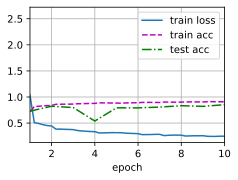

In [8]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数gamma和偏移参数beta

In [9]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.5869, 1.4984, 2.3834, 4.2451, 0.6009, 2.5244],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([3.6953, 1.8514, 3.0403, 2.1990, 1.2087, 2.0057],
        grad_fn=<ReshapeAliasBackward0>))

简明实现

In [10]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.269, train acc 0.900, test acc 0.771
6562.7 examples/sec on cpu


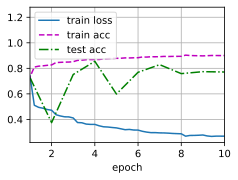

In [11]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())